In [0]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6

!pip install rasterio

!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
     | 180.0MB 3.5MB/s
  Created wheel for basemap: filename=basemap-1.2.1-cp36-cp36m-linux_x86_64.whl size=121756003 sha256=bb5f397e17c964f4d5cf89a220b2b55c00856a728bde03f08a1e9a3f61339ff7
  Stored in directory: /tmp/pip-ephem-wheel-cache-lagrjx8n/wheels/98/4a/fc/ce719b75d97e646645c225f3332b1b217536100314922e9572
Successfully built basemap
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (4.9.3-2).
proj-bin is already the newest version (4.9.3

In [0]:
import rasterio
import gdal

from pyproj import Proj, transform
from scipy.io import loadmat
 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from mpl_toolkits.basemap import Basemap

from numpy import meshgrid
import pandas as pd

%matplotlib inline

In [0]:
dset_gtiff = "/content/gpw_v4_population_count_rev11_2020_2pt5_min.tif"
gdal.AllRegister()
global ds
ds = gdal.Open(dset_gtiff)
band = ds.GetRasterBand(1)
arr = band.ReadAsArray()
ds_size = arr.shape
if band.GetMinimum() is None or band.GetMaximum() is None:
   band.ComputeStatistics(0)
      
print ("[ NO DATA VALUE ] = ", band.GetNoDataValue()) # none
print ("[ MIN ] = ", band.GetMinimum())
print ("[ MAX ] = ", band.GetMaximum())
print (ds_size)

ds.GetProjection()
dataGTIFF = ds.ReadAsArray()

[ NO DATA VALUE ] =  -3.4028230607370965e+38
[ MIN ] =  0.0
[ MAX ] =  1710353.125
(4320, 8640)


### Visualization of GeoTiff Dataset

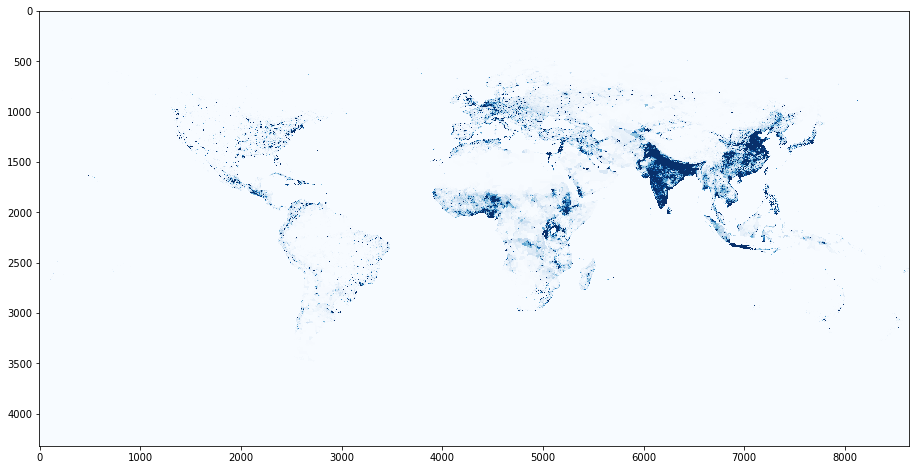

In [0]:
palette = plt.cm.Blues
palette.set_bad('808E94',0.75)

m = np.ma.array(dataGTIFF, mask=np.isnan(dataGTIFF))

plt.figure(figsize = (16,8))
plt.imshow(dataGTIFF, cmap = palette)
plt.clim(0, 5000)
plt.show()


### From Documentation
The population count data are divided by the land area data to create the population density rasters for each respective year. The pixels used in GPWv4 are quadrilaterals and therefore the area of each pixel decreases with increasing latitude. Additionally, the pixels in the land area data that include water reflect the net land area (total area of pixel – area of water within the pixel). This means that the population density data cannot be multiplied by a fixed land area size to estimate population totals without introducing error in some or all of the pixels. Multiplying the population density values by pixel area will overestimate population in pixels that contain water. If a fixed value for pixel area is used, it will also over or underestimate population totals for pixels that are all land as the area of these pixels varies by latitude. The population density data are best used to determine statistics (minimum, maximum, mean, etc.) within varying geographies. Users who need population totals should use the GPWv4 population count data.

In [0]:
def transform_coordinate(j, i, padfTransform):
  Yp = padfTransform[0] + i*padfTransform[1] + i*padfTransform[2];
  Xp = padfTransform[3] + j*padfTransform[4] + j*padfTransform[5];
  if Yp < 0:
    Yp += 360
  if Yp > 360:
    Yp -= 360
  return (Xp, Yp)

def population_binning(data, width = 1.25):
  pop_bins = np.zeros((int(90/width), int(280/width)))
  for i in range(len(data) // 2):
    for j in range(len(data[i])):
      coords = transform_coordinate(i, j, ds.GetGeoTransform())
      try:
        if (0 <= coords[0] <= 90) and (0 <= coords[1] <= 280) and data[i][j] >= 1:
          pop_bins[int(coords[0] / width)][int(coords[1] / width)] += round(data[i][j])
      except:
        print(coords)
  return pop_bins
    

### Visualization on the Projection for People-Hours

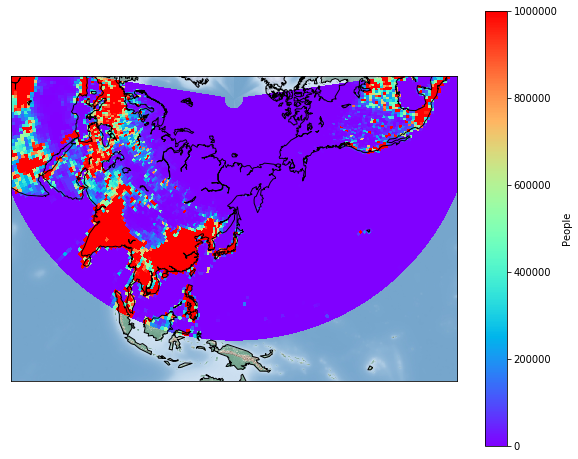

In [0]:
width = 1.25
a = population_binning(dataGTIFF, 1.25)
b = np.array([[float('nan') if num < 0 else num for num in row] for row in a])
y = np.arange(0,90, width)
x = np.arange(0,280,width)
fig = plt.figure(figsize = (10, 8))
hm = Basemap(projection='lcc', resolution='c',
        width=22E6, height=15E6, 
        lat_0=45, lon_0=140)
hm.shadedrelief(scale = 0.25)
xx,yy = meshgrid(x,y) #the colormap and colorbar will be different depending on anomaly's value
hm.pcolormesh(xx,yy, b, latlon=True, cmap='rainbow')
hm.drawcoastlines()
plt.clim(0, 1000000)
plt.colorbar(label='People')

In [0]:
def gather_data():
  all_data = [loadmat('TrackData_OMI_phase' + str(i + 1) + '.mat') for i in range(8)]
  eight_phase = []
  for dset in all_data:
    dset_lat = [row for row in dset['latstore']]
    dset_long = [row for row in dset['longstore']]
    hur_path = [zip(dset_lat[a], dset_long[a]) for a in range(4000)]
    eight_phase.append(hur_path)
  return eight_phase

In [0]:
def check_same_bin(x1, y1, x2, y2, width):
  return int(x1/width) == int(x2/width) and int(y1/width) == int(y2/width) 

def popxhours(population, hour_set):
  pop_hour_bins = [population*phase for phase in hour_set]
  pop_hour_bins = [[[float('nan') if num <= 0 else num for num in row] for row in data] for data in pop_hour_bins]
  return np.array(pop_hour_bins)
  
def create_pophour_maps(pop_set, hour_set, width = 1.25):
  y = np.arange(0,90, width)
  x = np.arange(0,280,width)
  all_ds = popxhours(pop_set, hour_set)
  for i in range(len(all_ds)):
    y = np.arange(0,90, width)
    x = np.arange(0,280,width)
    fig = plt.figure(figsize = (10, 8))
    hm = Basemap(projection='lcc', resolution='c',
            width=22E6, height=15E6, 
            lat_0=45, lon_0=140)
    hm.shadedrelief(scale = 0.125)
    xx,yy = meshgrid(x,y) #the colormap and colorbar will be different depending on anomaly's value
    hm.pcolormesh(xx,yy, all_ds[i], latlon=True, cmap='rainbow')
    hm.drawcoastlines()
    plt.clim(1, np.nanmax(all_ds)/100) #change later
    plt.colorbar(label='People-Hours')

In [0]:
def average_diff(population, hourset):
  hours = [population*hour for hour in hourset]
  return hours

In [0]:
def plot_hours(hourset):
  phase_plot = [1,2,3,4,5,6,7,8]
  hours = [np.nansum(phase) for phase in hourset]
  plt.plot(phase_plot, hours)
  plt.show()

In [0]:
def hour_binning(hurr_phases, width = 1.25):
  all_data = []
  for phase in hurr_phases:
    hour_bins = np.zeros((int(90/width), int(280/width))) #setting up a 2d-array for binning.
    for hurricane in phase:
      hurricane = list(hurricane)
      for i in range(len(hurricane[1:])):
        if hurricane[i] == (0.,0.): 
          break
        prev = hurricane[i-1]
        if check_same_bin(prev[0], prev[1], hurricane[i][0], hurricane[i][1], width):
          hour_bins[int(hurricane[i][0]/width)][int(hurricane[i][1] / width)] += 1
    all_data.append(hour_bins)
  return all_data

In [0]:
import random
def bootstrap_data(TCphases, samp_size, num_samples):
  phase_plot = [1,2,3,4,5,6,7,8]
  for sample in range(num_samples):
    small_phases = []
    for phase in TCphases:
      indicies = random.sample(range(0, len(phase)), samp_size)
      tempset = [phase[index] for index in indicies]
      small_phases.append(tempset)
    sample_bins = hour_binning(small_phases)
    sum_phase = [np.nansum(phase) for phase in sample_bins]
    plt.plot(phase_plot, sum_phase, linewidth = 0.1)
  plt.show()
    

In [0]:
binned_pop = population_binning(dataGTIFF)
all_paths = gather_data()
hour_set = hour_binning(all_paths)

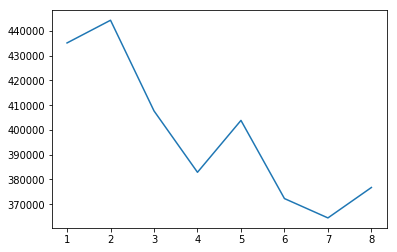

In [0]:
plot_hours(hour_set)

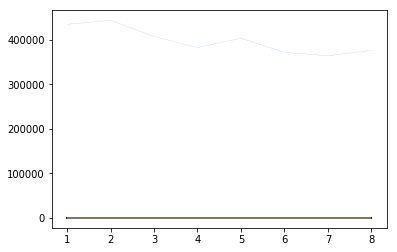

In [0]:
bootstrap_data(gather_data(), 4000, 4000)

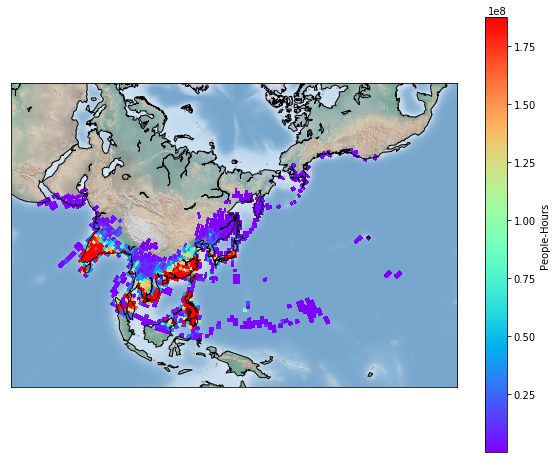

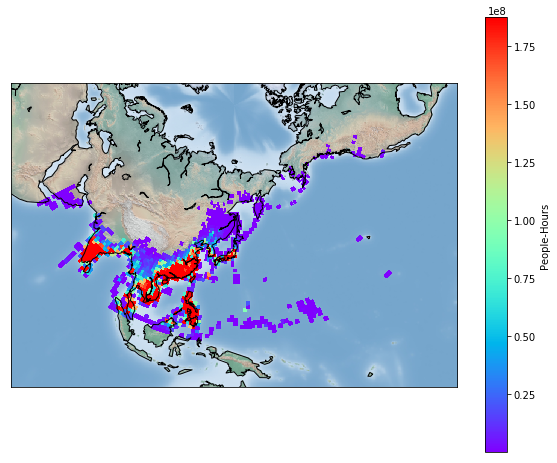

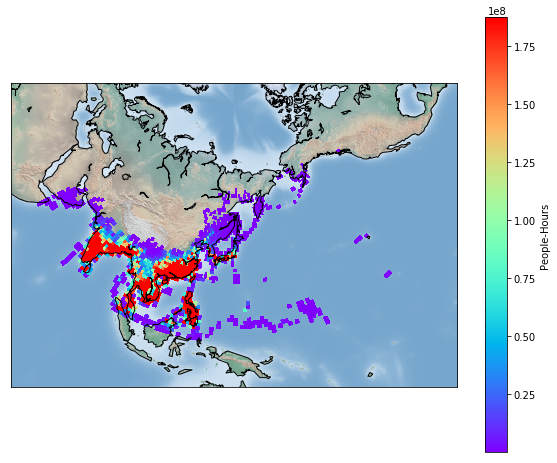

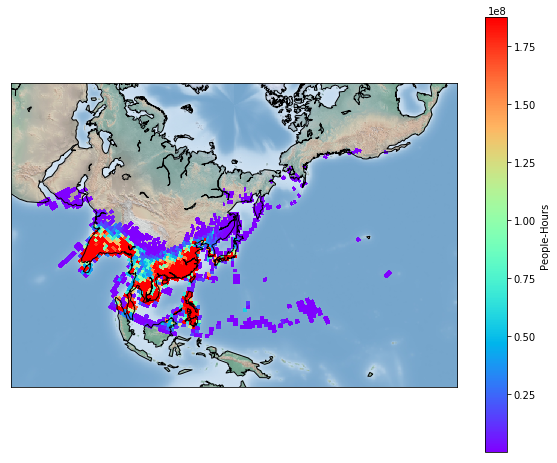

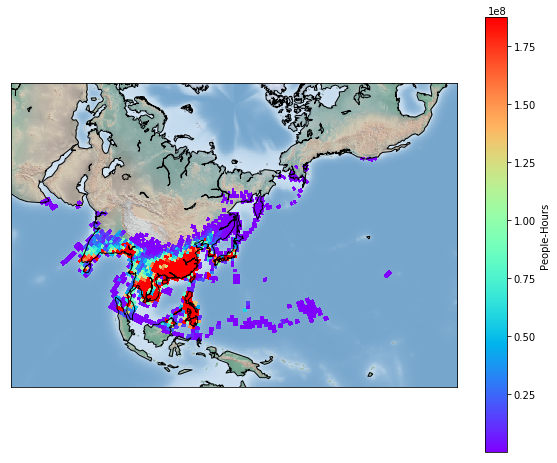

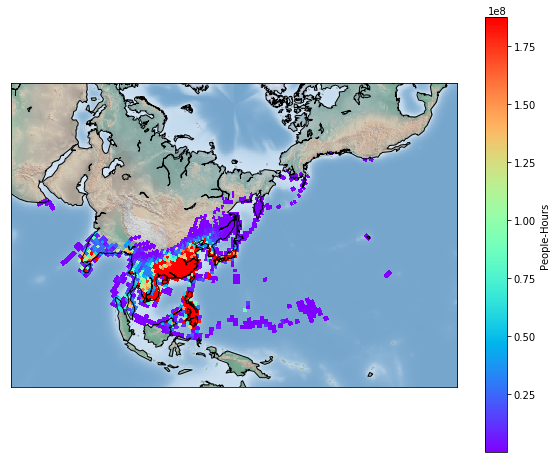

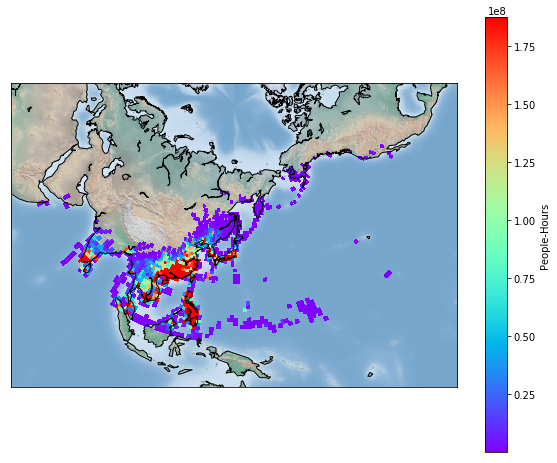

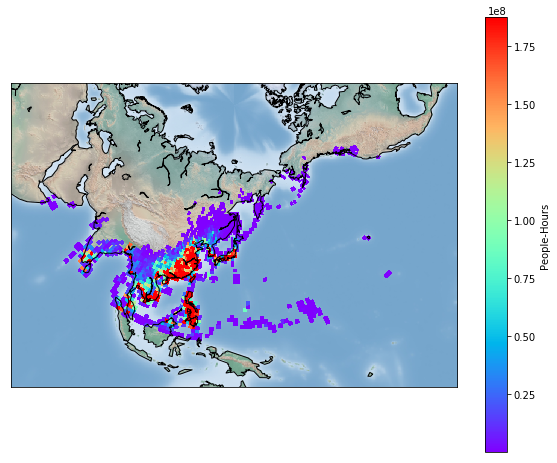

In [0]:
# from google.colab import files
create_pophour_maps(binned_pop, hour_set)
#all lines (besides the last line) must be uncommented to create the video
#in the next code block

# figures=[manager.canvas.figure
#        for manager in mpl._pylab_helpers.Gcf.get_all_fig_managers()]
# for i, figure in enumerate(figures):
#   figure.savefig('exposure_%d.png' % i)

In [0]:
import cv2
import os
from os.path import isfile, join
# from IPython.display import HTML
# figure out .avi / .mp4 and embedding within IPython file
# desired: create function so that this can be called on certain files
image_folder = "/content/"
video_name = 'HoursExposed.mp4'

images = [img for img in sorted(os.listdir(image_folder)) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

IndexError: ignored